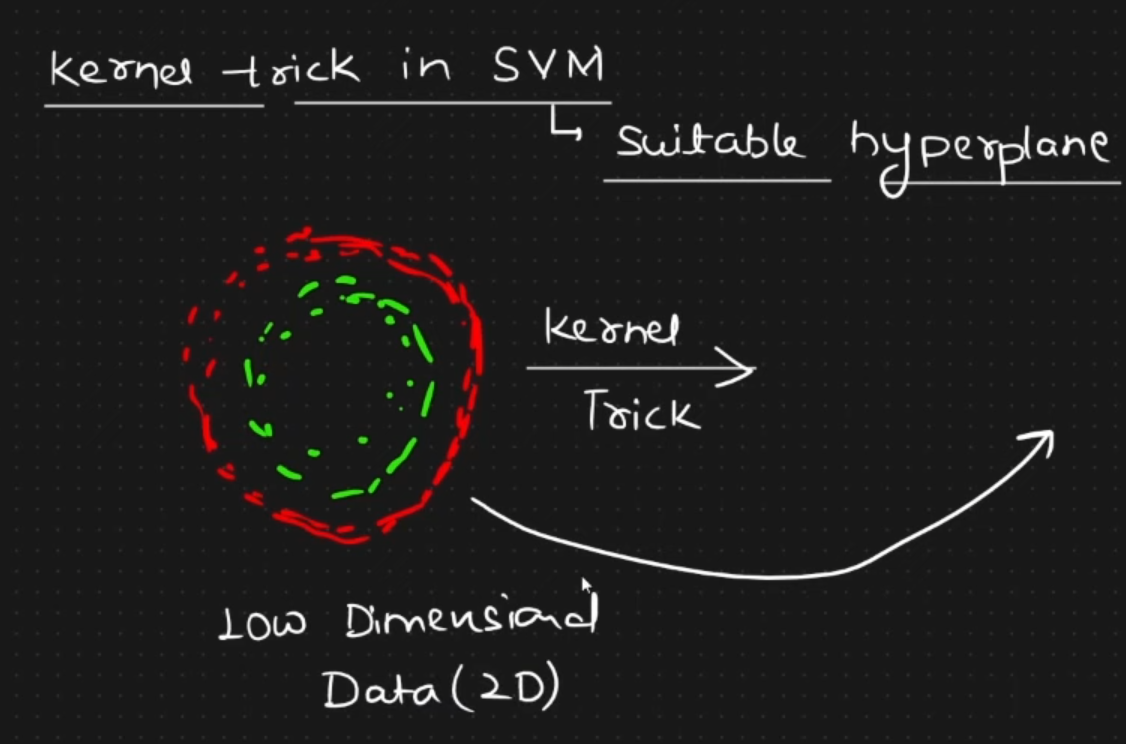

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder


In [ ]:
df = pd.read_csv(r"C:\Users\kaifk\lpth\.vscode\DataSciencePrac\003-Support-Vector-Machine-SVM-Example\applicant.csv")
df
names=[
        "Age","Workclass","fnlwgt","Education","Education-Num","Marital Status",
        "Occupation","Relationship","Race","Gender","Capital Gain","Capital Loss",
        "Hours per week","Country","Target"]
df.columns = names
df

In [ ]:
df.info()

In [ ]:
print(df.duplicated().sum()) #duplicated value encountered 
# percentage of duplicated values 
print(np.round(100*df.duplicated().sum()/len(df),1),"%")


In [ ]:
#checking for null values 
df.isna().sum() 
# no null values found 



In [ ]:
df.head()

In [ ]:
# lets check for the propotion of target variable ok i.e Target distribution

plt.figure(figsize=(12,6))
df.Target.value_counts().plot.pie(explode=[0.1,0.1],autopct = '%1.1f%%').set_title("Target Distribution ")
# can be seen that this is a  dispropotionate target distribution and to deal with this we might need to over sample the minority i.e >50K

In [ ]:
# lets analyze the features and plot them to better understand them with respect to the target 
plt.figure(figsize=(12,6))
sns.histplot(data = df , x = 'Age',hue='Target',kde =True,binwidth=1)
plt.title("Age count with respect to Target ")
plt.show()
# age is not playing a major role here but for the consideration we can take it as 
# age ranging from 20 - 80 are more likely to be in >50k category 
# and for the other it is not linearly dependent 


In [ ]:
selectintcol = df.select_dtypes('int').columns
selectintcol
fig=plt.figure(figsize=(20,30))
for i, var_name in enumerate(selectintcol):
    # Left plot
    ax=fig.add_subplot(6,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=False, hue='Target')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(6,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=True, hue='Target')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [ ]:
# no impact of captial gain and loss as they are merely all zero accross the population insight : drop them 
# Education num is a good feature 
# other features are no good use so we are keeping education - num as only feature selected from the dtypes int 
# fnlwght is also linearly independent 
df['Capital Loss'].value_counts().plot.pie()


In [ ]:
df['Capital Gain'].value_counts().plot.pie()


In [ ]:
df['Occupation'].value_counts()

In [ ]:
# categorical data viz 
cat_cols = df.select_dtypes('object').drop(['Target'], axis=1)
cat_cols = cat_cols.columns

# Plot categorical features
fig = plt.figure(figsize=(10, 16))
for i, var_name in enumerate(cat_cols):
    ax = fig.add_subplot(8, 1, i + 1)
    sns.countplot(data=df, x=var_name, ax=ax, hue='Target')
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

```python
we have found great results from this 
     - firstly we can clearly observe that the private sector workclass has the most > 50k and as well as the <=50k  
     - majority of >50k has education background as Bachleors  majority of <=50k have education as ms-grad 
     -  Married-civ-spouse has the highest >50k never married has the highest <=50k 
     - occupation plays a major role in identifying the target value  
     - relationship : husband is more likely to earn >50k and not in family person is <=50k
     - race (white dominant)
     - gender (male dominant in both aspect ) (crucial feature as most of females are <=50k)
     - country (restricted to US only as population majority lies there )
```
     

In [ ]:
#cat colms to encode : 
# important colms are gender ,education num , occupation , relationship , working hours

from sklearn.preprocessing import LabelEncoder

encodingcolms = ['Gender','Occupation','Relationship','Target']
def encode_colms(df,colms):
    le = LabelEncoder()
    for col in colms:
        df[col] = le.fit_transform(df[col].astype(str))
encode_colms(df,encodingcolms)
df.tail()


In [ ]:
df.dtypes

In [ ]:
df.groupby('Education-Num')['Target'].mean()
df.groupby('Education-Num').Target.mean().plot(kind='bar')
plt.show()

In [ ]:
!pip install imbalanced-learn


In [ ]:
#as we had seen that the male samples were over the females one so this might make model biased 
df['Gender'].value_counts().plot.pie(explode=[0.1, 0.1], autopct='%1.1f%%', labels=['Male', 'Female']).set_title("Gender Distribution")

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

x = df[['Gender','Occupation','Relationship','Education-Num','Age']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.2,random_state=40)

In [ ]:

# Perform cross-validation with StratifiedKFold and get predictions
Svm  = SVC(kernel='linear', random_state=40)
Svm.fit(X_train,y_train)
y_pred_cv= Svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_cv)
conf_matrix = confusion_matrix(y_test, y_pred_cv)
classification_rep = classification_report(y_test, y_pred_cv)
print(f"accuracy : {accuracy} \n conffusion matrix :\n {conf_matrix} \n classifaction report \n:{classification_rep}\n" )


In [ ]:
# using a Nueral Net and XGB to test if the accuracy varies along the models 
from keras import Sequential
from keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from sklearn.model_selection import GridSearchCV

def xgb(X_train,X_test,y_train,y_test):
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [150, 180, 220],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_classifier = XGBClassifier(random_state=42)
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters:", grid_search.best_params_)

    # Make predictions on the test data using the best model
    y_pred = grid_search.best_estimator_.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test Accuracy: {accuracy:.4f}')

# Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.9}
# Test Accuracy: 0.8259
xgb(X_train,X_test,y_train,y_test)

In [ ]:
# sequential nueral net 

def nueralnet(X_train,X_test,y_train,y_test):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(5,)),  
            tf.keras.layers.Dense(64, activation='tanh'),  # Dense hidden layer with ReLU activation
            tf.keras.layers.Dense(32,activation='tanh'),
            tf.keras.layers.Dense(1, activation='sigmoid')  
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
nueralnet(X_train,X_test,y_train,y_test)


> Accuracy is as follows : 
    </br>
    - nueral net with 2 hidden layer using activation function as tanh gave the highest accuracy that is `**82.67**`
    <br/>
    - xgb classifier with best param as Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.9} gave an accuracy of 82.59 %
    <br/>
    - svm gave the lowest accuracy 80.7 % 




In [ ]:
# over sampling failed
# from sklearn.utils import shuffle
# #  Split the data into male and female groups
# X_train_male = X_train[df['Gender'] == 1]
# y_train_male = y_train[df['Gender'] == 1]

# X_train_female = X_train[df['Gender'] == 0]
# y_train_female = y_train[df['Gender'] == 0]

# # Oversample the minority class only for females
# oversample_factor = 2 # You can adjust this factor based on your preference

# # Duplicate the original samples for females
# X_resampled_female = X_train_female
# y_resampled_female = y_train_female

# # Apply SMOTE to create synthetic samples for females
# smote_female = SMOTE(sampling_strategy=1.0, random_state=42)
# X_synthetic_female, y_synthetic_female = smote_female.fit_resample(X_train_female, y_train_female)

# # Combine the original and synthetic samples
# X_resampled_female = pd.concat([X_resampled_female] + [X_synthetic_female] * (oversample_factor - 1))
# y_resampled_female = pd.concat([y_resampled_female] + [y_synthetic_female] * (oversample_factor - 1))
# # Combine the resampled data for both genders
# X_resampled = pd.concat([X_train_male, X_resampled_female])
# y_resampled = pd.concat([y_train_male, y_resampled_female])

# X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)
# X_resampled.Gender.value_counts()